In [1]:
#Preprocessing functions:


In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def ppfft(f):
    #f is assumed N x N where N is even. If not, we just force it to be
    [h, w] = f.shape
    N = h
    f2 = f
    if h != w or np.mod(h, 2) == 1:
        N = int(np.ceil(max(h, w) / 2) * 2) #N is biggest dimension, but force even
        f2 = np.zeros([N, N])
        f2[N // 2 - int(h / 2):N // 2 - int(h / 2) + h, N // 2 - int(w / 2):N // 2 - int(w / 2) + w] = f
    ppff = np.zeros([2 * N, 2 * N]) * 1j

    #Constructing Quadrants 1 and 3
    ff = np.fft.fft(f2, N * 2, axis=0)
    ff = np.fft.fftshift(ff, 0)
    for i in range(-N, N):
        ppff[i + N, N - 1::-1] = fracfft(ff[i + N, :], i / (N ** 2), 1)

    #Constructing quadrants 2 and 4
    ff = np.fft.fft(f2, N * 2, axis=1)
    ff = np.fft.fftshift(ff, 1)
    ff = ff.T

    for i in range(-N, N):
        x = np.arange(0, N)
        factor = np.exp(1j * 2 * np.pi * x * (N / 2 - 1) * i / (N ** 2))
        ppff[i + N, N:2 * N] = fracfft(ff[i + N, :] * factor, i / (N ** 2))
    return ppff

In [4]:
def fracfft(f, alpha, centered=0):
    f = np.reshape(f.T, f.size)#flatten f
    N = len(f)#get length

    if centered == 1:
        x = np.arange(0, N)
        factor = np.exp(1j * np.pi * x * N * alpha)
        f = f * factor

    x = np.append(np.arange(0, N), np.arange(-N, 0))
    factor = np.exp(-1j * np.pi * alpha * x ** 2)
    ff = np.append(f, np.zeros(N))
    ff = ff * factor
    XX = np.fft.fft(ff)
    YY = np.fft.fft(np.conj(factor))

    result = np.fft.ifft(XX * YY)
    result = result * factor
    result = result[0:N]
    return result

In [5]:
import cv2

In [6]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
image = cv2.imread("/content/drive/MyDrive/signalfile/image.jpg")

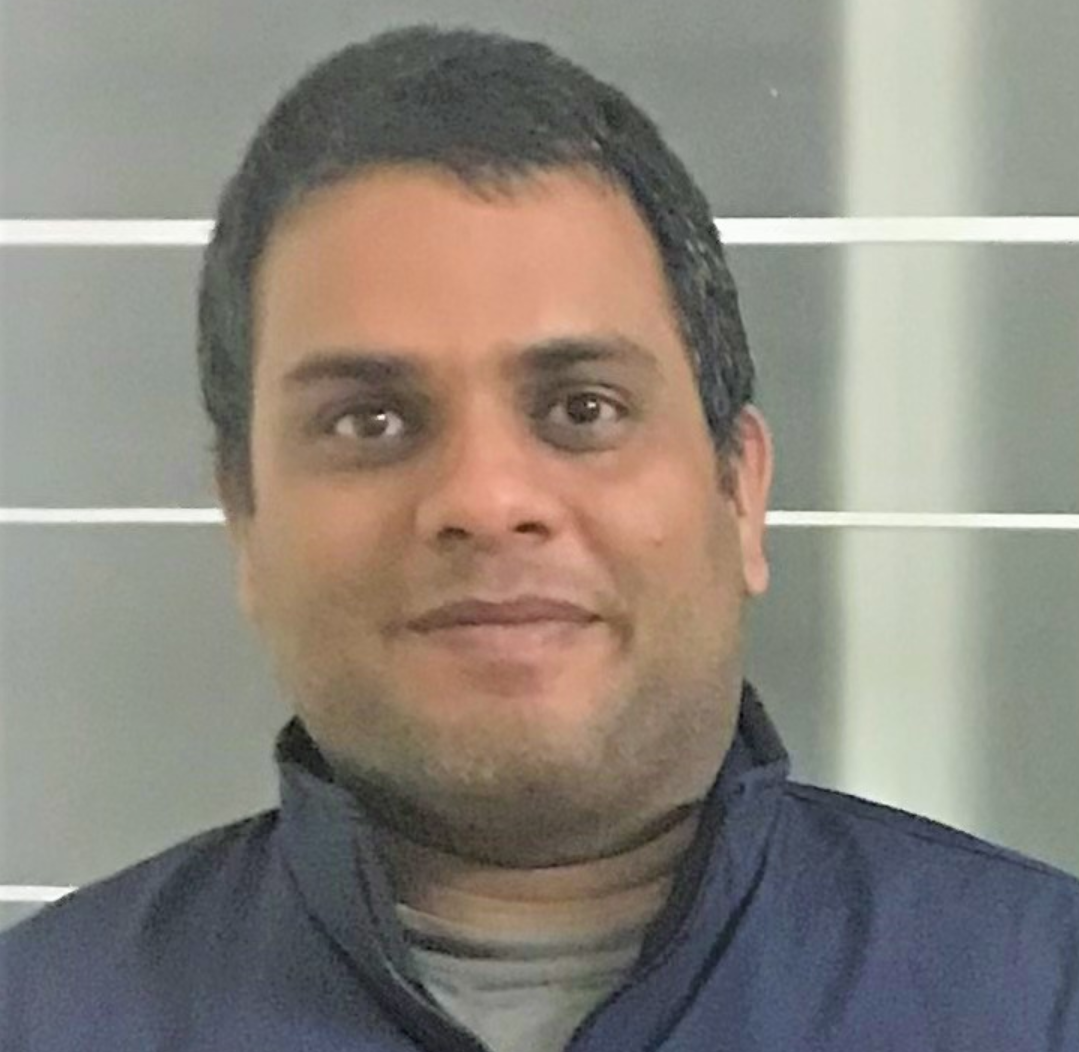

In [13]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)


In [14]:
f=image
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
[h, w] = f.shape
print(h)
print(w)

1052
1079


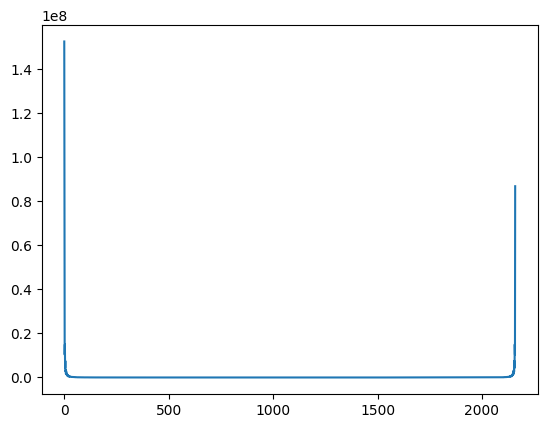

In [16]:

ppff=ppfft(f)
meanppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))
plt.plot(meanppff)

In [17]:
points=[10, 15, 20, 25, 30, 35, 40, 45, 50]

num = np.asarray(points) * np.pi
points = num / np.round(len(meanppff) / 2)

W = f.shape[1]
H = f.shape[0]
points

array([0.02908882, 0.04363323, 0.05817764, 0.07272205, 0.08726646,
       0.10181087, 0.11635528, 0.13089969, 0.1454441 ])

In [18]:
def ewt_beta(x):
    bm = (x >= 0) * (x <= 1) \
        * (x ** 4 * (35 - 84 * x + 70 * x ** 2 - 20 *x **3))
    bm += (x > 1)
    return bm

In [19]:

def ewt2d_LPscaling(radii, bound0, gamma):
    an = 1 / (2 * gamma * bound0)
    mbn = (1 - gamma) * bound0 # inner circle up to beginning of transtion
    pbn = (1 + gamma) * bound0 #end of transition

    scaling = 0 * radii #initiate w/ zeros
    scaling[radii < mbn] = 1
    scaling[radii >= mbn] = np.cos(np.pi * ewt_beta(an * (radii[radii >= mbn] - mbn)) / 2)
    scaling[radii > pbn] = 0
    return scaling

In [20]:
def ewt2d_LPwavelet(radii, bound1, bound2, gamma):
    wan = 1 / (2 * gamma * bound1) #scaling factor
    wam = 1 / (2 * gamma * bound2)
    wmbn = (1 - gamma) * bound1 #beginning of lower transition
    wpbn = (1 + gamma) * bound1 #end of lower transition
    wmbm = (1 - gamma) * bound2  #beginning of upper transition
    wpbm = (1 + gamma) * bound2 #end of upper transition

    wavelet = 0 * radii #initialize w/ zeros
    inside = (radii > wmbn) * (radii < wpbm)
    wavelet[inside] = 1.0 #set entire angular wedge equal to 1
    temp = inside*(radii >= wmbm) * (radii <= wpbm) #upper transition
    wavelet[temp] *= np.cos(np.pi * ewt_beta(wam * (radii[temp] - wmbm)) / 2)
    temp = inside * (radii >= wmbn) * (radii <= wpbn) #lower transition
    wavelet[temp] *= np.sin(np.pi * ewt_beta(wan * (radii[temp] - wmbn)) / 2)
    return wavelet


In [21]:
def ewt2d_LPFilterbank(bounds_scales, h, w):
    if h % 2 == 0:
        h += 1
        h_extended = 1
    else:
        h_extended = 0
    if w % 2 == 0:
        w += 1
        w_extended = 1
    else:
        w_extended = 0
    #First, we calculate gamma for scales
    gamma_scales = np.pi
    for k in range(0, len(bounds_scales) - 1):
        r = (bounds_scales[k + 1] - bounds_scales[k]) / (bounds_scales[k + 1] + bounds_scales[k])
        if r < gamma_scales and r > 1e-16:
            gamma_scales = r
    r = (np.pi - bounds_scales[-1]) / (np.pi + bounds_scales[-1]) #check last bound
    if r < gamma_scales and r > 1e-16:
        gamma_scales = r

    if gamma_scales > bounds_scales[0]:     #check first bound
        gamma_scales = bounds_scales[0]
    gamma_scales *= (1 - 1 / max(h, w)) #guarantees that we have strict inequality
    radii = np.zeros([h, w])

    h_center = h // 2 + 1
    w_center = w // 2 + 1
    for i in range(0, h):
        for j in range(0, w):
            ri = (i + 1.0 - h_center) * np.pi / h_center
            rj = (j + 1.0 - w_center) * np.pi / w_center
            radii[i, j] = np.sqrt(ri ** 2 + rj ** 2)

    mfb = []
    mfb.append(ewt2d_LPscaling(radii, bounds_scales[0], gamma_scales))
    for i in range(0, len(bounds_scales) - 1):
        mfb.append(ewt2d_LPwavelet(radii, bounds_scales[i], bounds_scales[i + 1], gamma_scales))
    mfb.append(ewt2d_LPwavelet(radii, bounds_scales[-1], 2 * np.pi, gamma_scales))

    if h_extended == 1: #if we extended the height of the image, trim
        h -= 1
        for i in range(0, len(mfb)):
            mfb[i] = mfb[i][0:-1, :]
    if w_extended == 1: #if we extended the width of the image, trim
        w -= 1
        for i in range(0, len(mfb)):
            mfb[i] = mfb[i][:, 0:-1]
    #invert the fftshift since filters are centered
    for i in range(0, len(mfb)):
        mfb[i] = np.fft.ifftshift(mfb[i])

    #Resymmetrize for even images
    if h_extended == 1:
        s = np.zeros(w)
        if w % 2 == 0:
            mfb[-1][h // 2, 1:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2 - 1:0:-1]
            s += mfb[-1][h // 2, :] ** 2
            #normalize for tight frame
            mfb[-1][h // 2, 1:w // 2] /= np.sqrt(s[1:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
        else:
            mfb[-1][h // 2, 0:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2-1::-1]
            s += mfb[-1][h // 2, :] ** 2
            #normalize for tight frame
            mfb[-1][h // 2, 0:w // 2]  /= np.sqrt(s[0:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
    if w_extended == 1:
        s = np.zeros(h)
        if h%2 == 0:
            mfb[-1][1:h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1:0:-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            #normalize for tight frame
            mfb[-1][1:h // 2, w // 2] /= np.sqrt(s[1:h // 2])
            mfb[-1][h // 2 + 1:, w // 2] /= np.sqrt(s[h // 2 + 1:])
        else:
            mfb[-1][0 : h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1::-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            #normalize for tight frame
            mfb[-1][0:h // 2, w // 2] /= s[0:h // 2]
            mfb[-1][h // 2 + 1:, w // 2] /= s[h // 2 + 1:]
    return mfb



In [22]:
mfb = ewt2d_LPFilterbank(points, H, W)
#filter out coefficients
ff = np.fft.fft2(f)
ewtLP = [None] * len(mfb)
for k in range(len(mfb)):
    ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

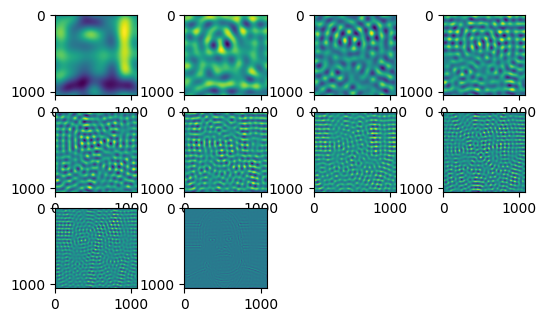

In [23]:
plt.figure()
for m in range(len(mfb)):
    plt.subplot(4, 4, m+1)
    xx = ewtLP[m]
    plt.imshow(xx)

In [24]:
#Loading Dataset:
!pip install -q kaggle


In [25]:
%mkdir dataset
%mkdir dataset/images # for source images
%mkdir dataset/masks # for annotation masks
%mkdir dataset/test # for test images
%mkdir dataset/temp # temp storage


In [26]:
# start the download
!kaggle datasets download 'nikhilpandey360/chest-xray-masks-and-labels'

Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
License(s): CC0-1.0
100% 9.58G/9.58G [02:19<00:00, 112MB/s]
100% 9.58G/9.58G [02:19<00:00, 73.6MB/s]


In [27]:
!unzip chest-xray-masks-and-labels.zip -d dataset/temp/


Archive:  chest-xray-masks-and-labels.zip
  inflating: dataset/temp/Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
 

In [28]:
%ls dataset/temp/Lung\ Segmentation

ClinicalReadings/  masks/                       NLM-MontgomeryCXRSet-ReadMe.pdf
CXR_png/           NLM-ChinaCXRSet-ReadMe.docx  test/


In [29]:
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/images/
IMAGE_PATH = "/content/dataset/images/"

In [39]:
%mkdir /content/transformed_images

In [49]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Assuming fb2DEWT and related functions are already defined in your notebook
# Load 50 images from your dataset (e.g., stored in dataset/images)
image_dir = '/content/dataset/images'  # Path to your images folder
output_dir = '/content/dataset/transformed_images'  # Where to save the transformed components
os.makedirs(output_dir, exist_ok=True)

num=5

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])[:num]

In [50]:
#PREPROCESS and save the images

In [52]:
def process_and_save_image(image_path, output_path, image_name):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply fb2DEWT (Filter Bank 2D Empirical Wavelet Transform)
    ppff = ppfft(gray_image)
    meanppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))
    points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
    num = np.asarray(points) * np.pi
    points = num / np.round(len(meanppff) / 2)

    H, W = gray_image.shape
    mfb = ewt2d_LPFilterbank(points, H, W)

    # Filter out coefficients
    ff = np.fft.fft2(gray_image)
    ewtLP = [np.real(np.fft.ifft2(np.conj(mfb[k]) * ff)) for k in range(len(mfb))]

    # Save each component as a .npy file
    transformed_components = np.stack(ewtLP, axis=0)  # Stack them into one array (channels, H, W)
    np.save(os.path.join(output_path, f'{image_name}_transformed.npy'), transformed_components)

# Process and save 50 images
cnt=1
num-=2
print('Transforming Images:')
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    image_name = os.path.splitext(image_file)[0]
    process_and_save_image(image_path, output_dir, image_name)
    print(f'processed image {cnt}/{num}')
    cnt+=1

print(f"Processed and saved transformed images in {output_dir}")

Transforming Images:
processed image 0/3
processed image 1/3
processed image 2/3
processed image 3/3
processed image 4/3
Processed and saved transformed images in /content/dataset/transformed_images


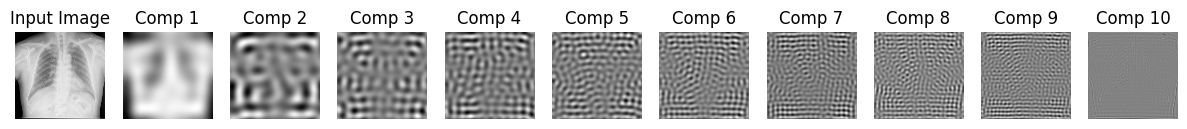

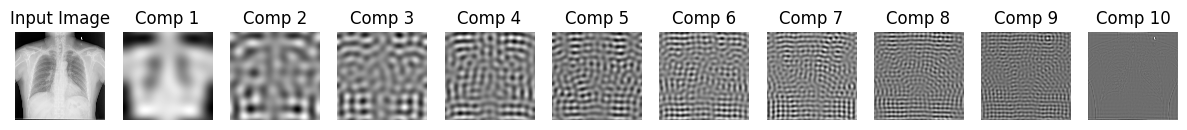

Displayed input and transformed images.


In [54]:
# Paths to input images and transformed images
input_dir = '/content/dataset/images'
transformed_dir = '/content/dataset/transformed_images'
# List input and transformed files (assuming file names match between input and output)
input_images = sorted([f for f in os.listdir(input_dir) if f.endswith(('.png'))])[:2]  # First 2 images
transformed_files = sorted([f for f in os.listdir(transformed_dir) if f.endswith('.npy')])[:2]  # First 2 transformed sets

# Loop through the first 2 images
for input_image, transformed_file in zip(input_images, transformed_files):
    # Load the input image
    input_img = cv2.imread(os.path.join(input_dir, input_image))
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying

    # Load the transformed components
    transformed_components = np.load(os.path.join(transformed_dir, transformed_file))

    # Create a figure to display the input and its components
    plt.figure(figsize=(15, 5))

    # Show the original input image
    plt.subplot(1, 11, 1)
    plt.imshow(input_img)
    plt.title('Input Image')
    plt.axis('off')

    # Show the 10 transformed components side by side
    for i in range(10):
        plt.subplot(1, 11, i+2)
        plt.imshow(transformed_components[i], cmap='gray')
        plt.title(f'Comp {i+1}')
        plt.axis('off')

    plt.show()

print("Displayed input and transformed images.")

**MODIFIED UNET:**

In [55]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Change the input shape to (512, 512, 10) to match the new data format
unet_model = build_unet((512, 512, 10))
